# Machine Learning for Life Science: Project 2 - Multilabel Protein Localization Prediction

# DATA

In [1]:
import os
import sys
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer

train_labels = './data/train.csv'
train_images = './data/train/'

test_submission = './data/submission.csv'
test_images = './data/test/'

BATCH_SIZE = 16

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# variable for device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


   Image Label
0  12874   1 4
1  21466     0
2   3610     4 

   Image  0  1  2  3  4  5  6  7  8  9
0  12874  0  1  0  0  1  0  0  0  0  0
1  21466  1  0  0  0  0  0  0  0  0  0
2   3610  0  0  0  0  1  0  0  0  0  0


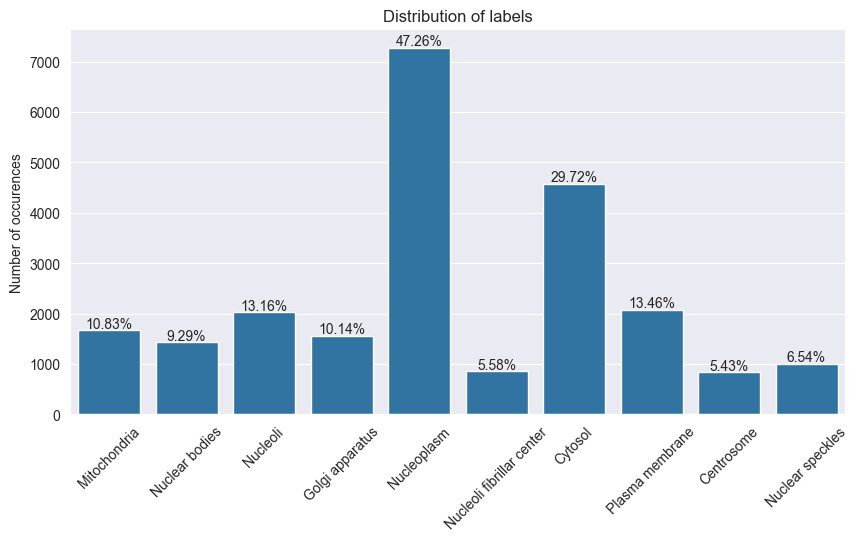

In [2]:
df = pd.read_csv(train_labels)
print(df.head(3), '\n')
mlb = MultiLabelBinarizer()
df['Label'] = df['Label'].apply(lambda x: x.split(' '))
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('Label')),
                          columns=mlb.classes_,
                          index=df.index))
print(df.head(3))

# plot the distribution of labels with seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df.columns[1:], y=df.iloc[:, 1:].sum().values)
plt.title("Distribution of labels")
plt.ylabel("Number of occurences")
plt.xlabel("")
plt.xticks(range(10), [label_map[i] for i in range(10)])
plt.xticks(rotation=45)
for i, v in enumerate(df.iloc[:, 1:].sum().values):
    ax.text(i, v + 50, str(np.round(100 * v / df.shape[0], 2)) + '%', ha="center")
plt.show()

In [3]:
# multi-label stratified split of the dataset into train and validation sets
from skmultilearn.model_selection import iterative_train_test_split

X = df['Image']
y = df.drop(columns=['Image'])

X_train, y_train, X_val, y_val = iterative_train_test_split(X.values.reshape(-1, 1), y.values, test_size=0.1)
X_test = pd.read_csv(test_submission)['Image'].values.reshape(-1, 1)

print('Train:', X_train.shape, y_train.shape)
print('Val:', X_val.shape, y_val.shape)
print('Test:', X_test.shape)

Train: (13853, 1) (13853, 10)
Val: (1536, 1) (1536, 10)
Test: (3847, 1)


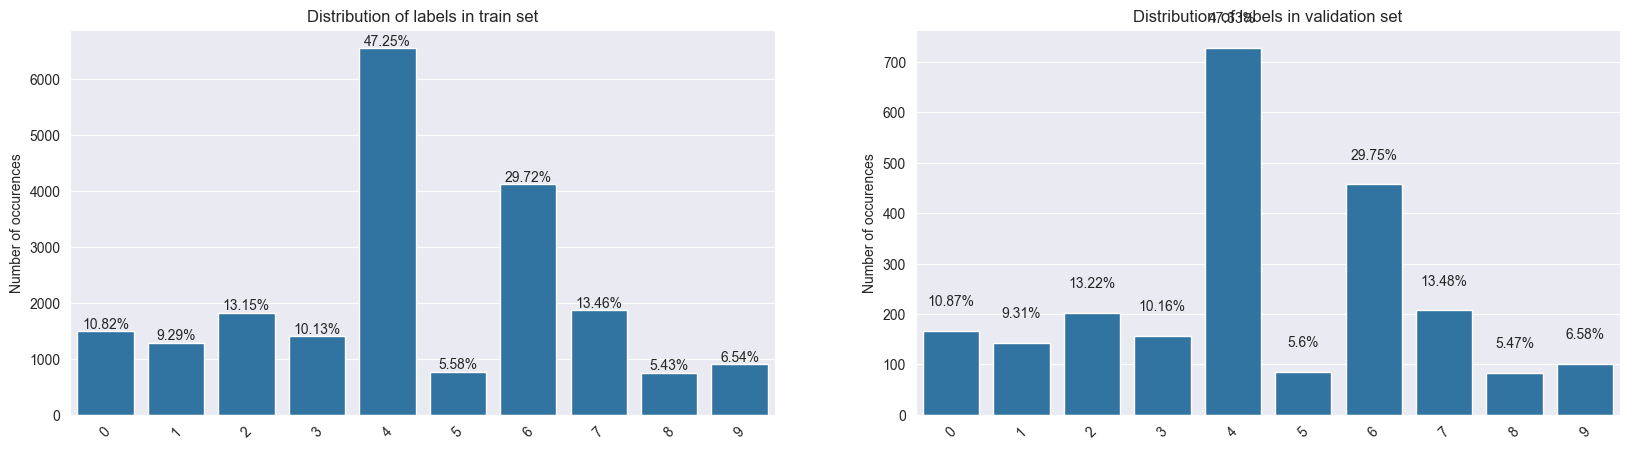

In [4]:
# plot distribution of labels in train and validation sets
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
ax = sns.barplot(x=range(10), y=y_train.sum(axis=0))
plt.title("Distribution of labels in train set")
plt.ylabel("Number of occurences")
plt.xlabel("")
plt.xticks(rotation=45)
for i, v in enumerate(y_train.sum(axis=0)):
    ax.text(i, v + 50, str(np.round(100 * v / y_train.shape[0], 2)) + '%', ha="center")

plt.subplot(1, 2, 2)
ax = sns.barplot(x=range(10), y=y_val.sum(axis=0))
plt.title("Distribution of labels in validation set")
plt.ylabel("Number of occurences")
plt.xlabel("")
plt.xticks(rotation=45)
for i, v in enumerate(y_val.sum(axis=0)):
    ax.text(i, v + 50, str(np.round(100 * v / y_val.shape[0], 2)) + '%', ha="center")
plt.show()

In [5]:
from torchvision import transforms

class HumanProteinDataset(Dataset):
    def __init__(self, X, y=None, data_dir='./data/train/', transform=None, balance_classes=False):
        super().__init__()

        self.data_dir = data_dir
        self.X = [data_dir + str(name) + '.png' for name in X[:, 0]]
        self.transform = transform
        if y is not None:
            self.y = y.astype(np.float32)

            if balance_classes:
                class_counts = y.sum(axis=0)
                self.class_weights = len(y) / (len(class_counts) * class_counts)
                self.sample_weights = torch.from_numpy(np.array([self.class_weights[class_idx] for class_idx in np.argmax(y, axis=1)]))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = read_image(self.X[index]) / 255.0
        if self.transform:
            image = self.transform(image)
        if hasattr(self, 'y'):
            label = torch.from_numpy(self.y[index])
            if hasattr(self, 'sample_weights'):
                return image, label, self.sample_weights[index]
            else:
                return image, label
        else:
            return image

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(128, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
])

train_dataset = HumanProteinDataset(X=X_train, y=y_train, data_dir=train_images, transform=train_transform, balance_classes=True)
val_dataset = HumanProteinDataset(X=X_val, y=y_val, data_dir=train_images)
test_dataset = HumanProteinDataset(X=X_test, data_dir=test_images)

Number of samples:  13853
Shape of image:  torch.Size([3, 128, 128])
Shape of label:  torch.Size([10]) 


Example image:


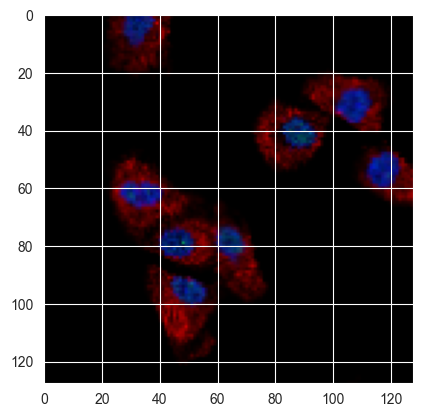

In [6]:
print('Number of samples: ', len(train_dataset))
print('Shape of image: ', train_dataset[0][0].shape)
print('Shape of label: ', train_dataset[0][1].shape, '\n\n')

print('Example image:')
plt.imshow(train_dataset.__getitem__(0)[0].permute(1, 2, 0))

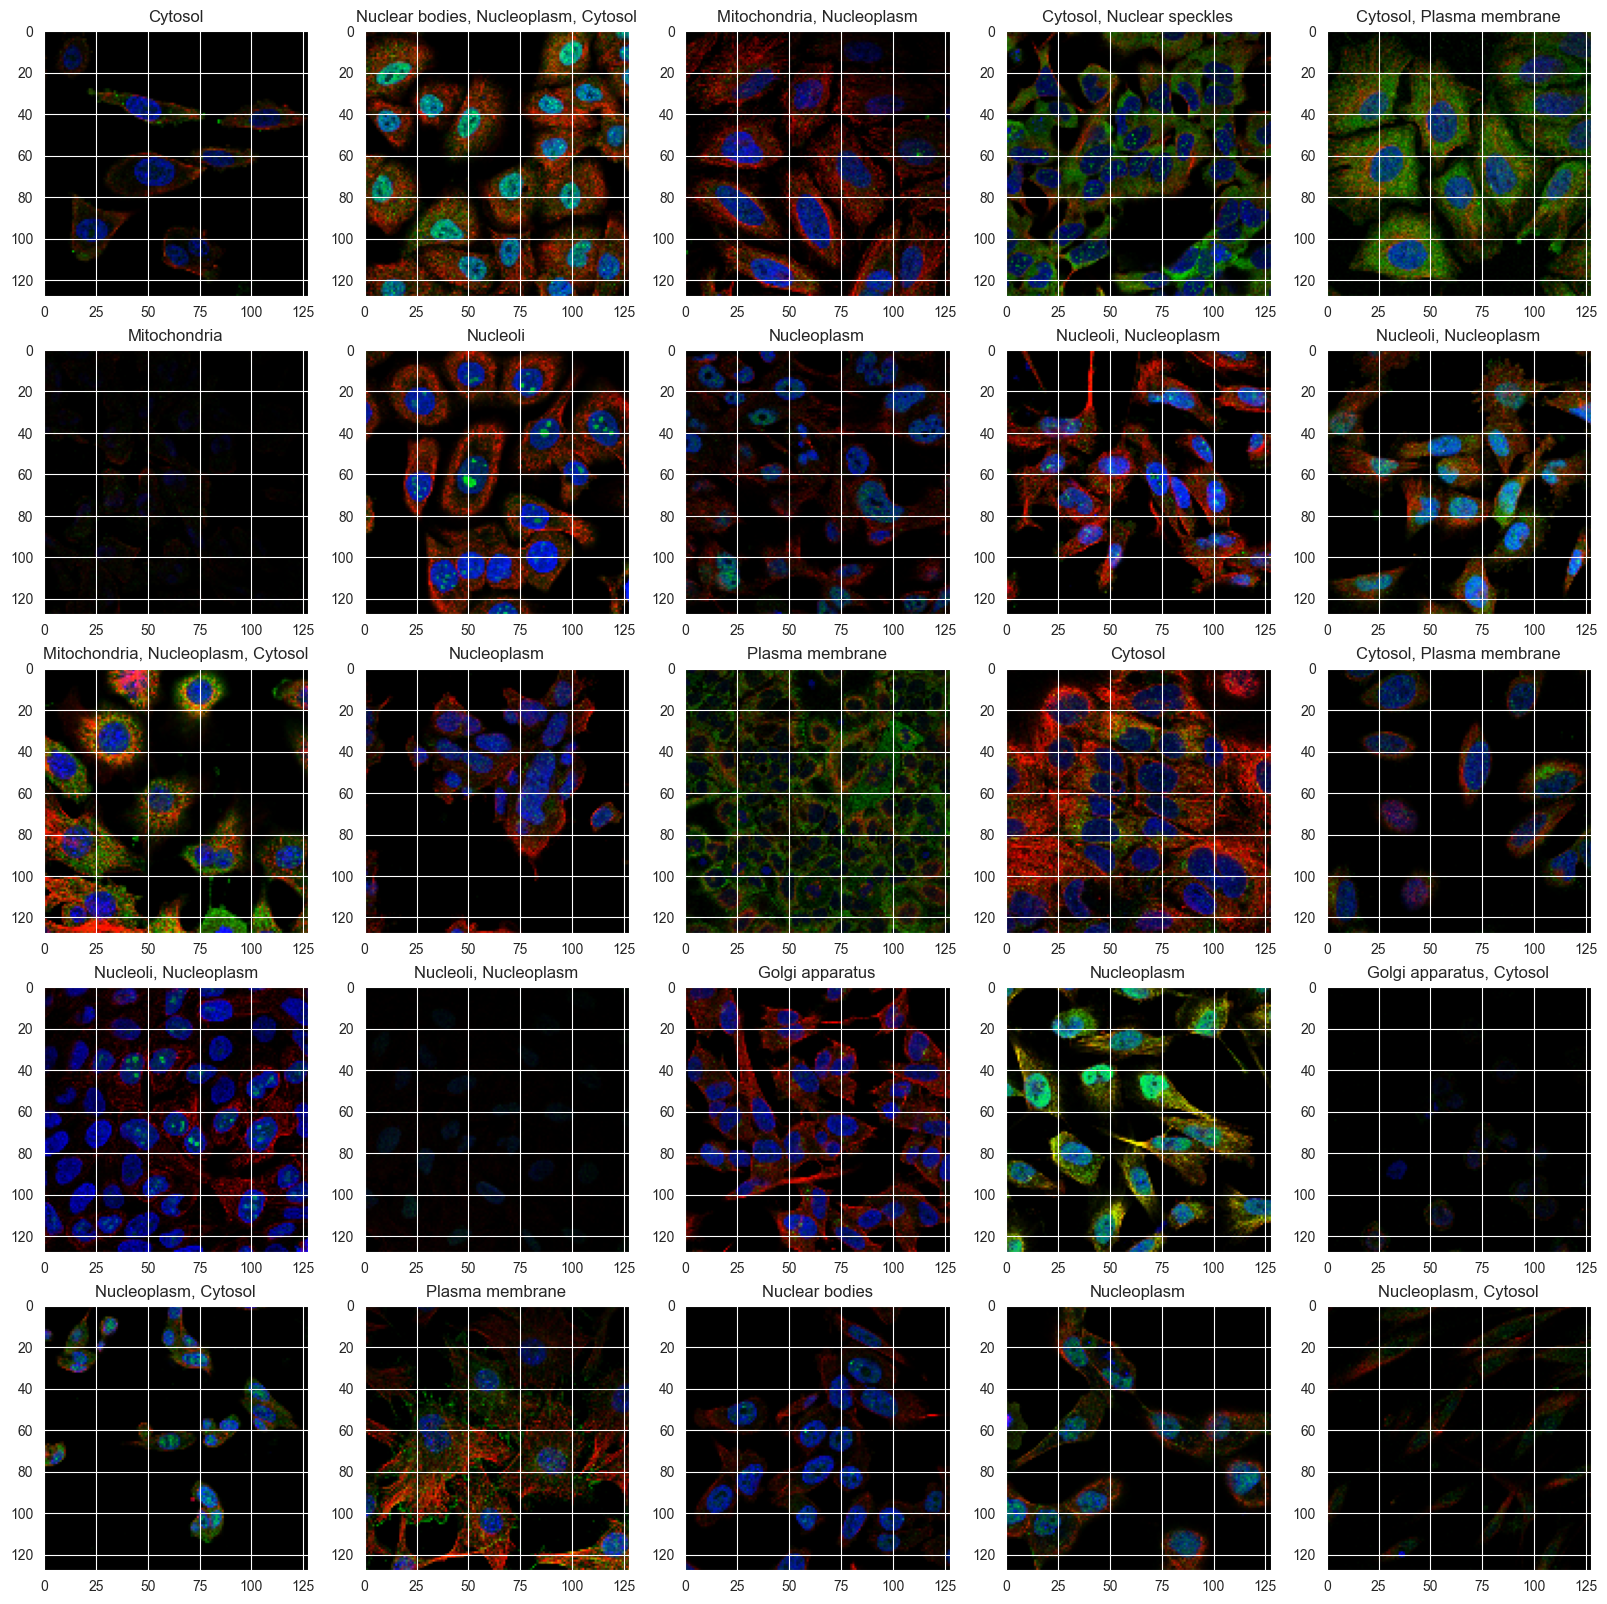

In [7]:
# plot several random train_dataset images with their labels (translated with label_map)
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image, label = val_dataset[np.random.randint(0, len(val_dataset))]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(', '.join(list([label_map[i] for i in np.where(label)[0]])))
plt.show()

In [8]:
if hasattr(train_dataset, 'sample_weights'):
    train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.sample_weights.type('torch.DoubleTensor'), len(train_dataset))
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# test dataloader
test_batch = train_dataloader.__iter__().__next__()
print('Test batch shape\n', test_batch[0].shape, test_batch[1].shape)

Test batch shape
 torch.Size([16, 3, 128, 128]) torch.Size([16, 10])


In [9]:
# example softmax and sigmoid output on a random batch
import torch.nn.functional as F

print(test_batch[1][0])
print('Softmax output:\n', F.softmax(test_batch[1], dim=1)[0])
print('Sigmoid output:\n', torch.sigmoid(test_batch[1][0]))

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Softmax output:
 tensor([0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853, 0.0853, 0.0853,
        0.0853])
Sigmoid output:
 tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.7311, 0.5000, 0.5000, 0.5000,
        0.5000])


In [10]:
# class ChannelAttentionBlock(nn.Module):
#     def __init__(self, channels = 64):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, channels, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att

# class SpatialAttentionBlock(nn.Module):
#     def __init__(self, channels = 64):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, 1, 1),
#             nn.BatchNorm2d(1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att


# class ResidualBlock(nn.Module):
#     def __init__(self, channels = 64, kernel_size = 3):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(),
#             nn.Conv2d(channels, channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(),
#             )

#         self.att_c = ChannelAttentionBlock(channels)
#         self.att_s = SpatialAttentionBlock(channels)

#     def forward(self, x):
#         out = self.net(x)
#         att_c = self.att_c(out)
#         att_s = self.att_s(out)
#         # normalize attention weights
#         att_c = att_c / (att_c + att_s)
#         att_s = att_s / (att_c + att_s)
#         # apply attention weights
#         out = (out * att_c) + (out * att_s)

#         return out + x


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size = 3, dropout_rate = 0.3):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             )

#     def forward(self, x):
#         return self.net(x)


# class CNNBackBone(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.Conv8 = ConvBlock(3, 8, kernel_size=3)
#         self.Conv16 = ConvBlock(8, 16, kernel_size=3)
#         self.Conv24 = ConvBlock(16, 24, kernel_size=1)

#         self.Res8 = ResidualBlock(channels=8)
#         self.Res16 = ResidualBlock(channels=16)

#         self.Norm8 = nn.BatchNorm2d(8)
#         self.Norm16 = nn.BatchNorm2d(16)

#         self.Maxpool = nn.MaxPool2d(2)

#     def forward(self, x):
#         x = self.Conv8(x)
#         x = self.Res8(x)
#         x = self.Norm8(x)
#         x = self.Maxpool(x)

#         x = self.Conv16(x)
#         x = self.Res16(x)
#         x = self.Norm16(x)
#         x = self.Maxpool(x)

#         x = self.Conv24(x)
#         x = self.Maxpool(x)

#         return x

# print("Feature representation shape: ", CNNBackBone()(test_batch[0]).shape)

# class LinearBlock(nn.Module):
#     def __init__(self, in_features, out_features, dropout_rate=0.2):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Linear(in_features, out_features),
#             nn.ReLU(),
#             nn.BatchNorm1d(out_features),
#             nn.Dropout(dropout_rate),
#         )

#     def forward(self, x):
#         return self.net(x)

# class CNNHead(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Flatten(),
#             LinearBlock(24 * 16 * 16, 64),
#             nn.Linear(64, 10),
#             # nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.net(x)

# class ProteinLocalizer(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.backbone = CNNBackBone()
#         self.head = CNNHead()

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.head(x)
#         return x

# test_model = ProteinLocalizer()

# # check output shape
# test_x = torch.randn(32, 3, 128, 128)
# print(test_model(test_x).shape)          # >>> torch.Size([32, 10])
# print(test_model(test_batch[0]).shape)   # >>> torch.Size([32, 10])

# # check number of parameters
# sum([p.numel() for p in test_model.parameters()])

In [11]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels=16, out_channels=16, kernel_size=3, stride=1, bias=False, padding='same'):
#         super().__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=bias)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.LeakyReLU(negative_slope=0.1)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=bias)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = self.relu(out)

#         return out


# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size = 3, dropout_rate = 0.5, padding = 'same', stride=1, dilation=1):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, dilation=dilation),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             )

#     def forward(self, x):
#         return self.net(x)


# class ChannelGate(nn.Module):
#     def __init__(self, channels, reduction_ratio = 8):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(channels, channels // reduction_ratio, 1),
#             nn.ReLU(),
#             nn.Conv2d(channels // reduction_ratio, channels, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att


# class SpatialGate(nn.Module):
#     def __init__(self, channels):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(channels, 1, 1),
#             nn.BatchNorm2d(1),
#             nn.ReLU(),
#             nn.Conv2d(1, 1, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att


# class CellDetectionModel(nn.Module):
#     def __init__(self):
#         super(CellDetectionModel, self).__init__()

#         # Define the architecture for cell detection
#         self.ConvBlock = ConvBlock(3, 16, kernel_size=3)
#         self.ConvBlock_stride = ConvBlock(3, 16, kernel_size=3, stride=2, padding=0)
#         self.ConvBlock_dilate = ConvBlock(3, 16, kernel_size=3, dilation=2)

#         self.ResBlock1 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock2 = ResidualBlock(16, 16, kernel_size=3)
#         self.ResBlock_stride1 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock_stride2 = ResidualBlock(16, 16, kernel_size=3)
#         self.ResBlock_dilate1 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock_dilate2 = ResidualBlock(16, 16, kernel_size=3)

#         self.SpatialGate = SpatialGate(16)
#         self.SpatialGate_stride = SpatialGate(16)
#         self.SpatialGate_dilate = SpatialGate(16)

#         self.StrideTransposer = nn.Sequential(nn.ConvTranspose2d(16, 16, 1, stride=2), nn.ZeroPad2d((0, 3, 0, 3)))
#         self.Compressor = ConvBlock(16, 3, 1)
#         self.Sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Forward pass for cell detection
#         out = self.ResBlock1(self.ConvBlock(x))
#         out_stride = self.ResBlock_stride1(self.ConvBlock_stride(x))
#         out_dilate = self.ResBlock_dilate1(self.ConvBlock_dilate(x))

#         out = out * self.SpatialGate(out)
#         out_stride = out_stride * self.SpatialGate_stride(out_stride)
#         out_dilate = out_dilate * self.SpatialGate_dilate(out_dilate)

#         out_stride = self.StrideTransposer(out_stride)

#         out = self.Compressor(out + out_stride + out_dilate)
#         return self.Sigmoid(out)


# class ProteinLocalizationModel(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ProteinLocalizationModel, self).__init__()

#         # Define the architecture for protein localization within cells
#         self.ConvBlock1 = ConvBlock(3, 8, kernel_size=3)
#         self.ConvBlock2 = ConvBlock(8, 16, kernel_size=3)
#         # self.ConvBlock3 = ConvBlock(16, 32, kernel_size=3)

#         self.ResBlock1 = ResidualBlock(8, 8, kernel_size=3)
#         self.ResBlock2 = ResidualBlock(16, 16, kernel_size=3)
#         # self.ResBlock3 = ResidualBlock(32, 32, kernel_size=3)

#         self.ChannelGate1 = ChannelGate(8)
#         self.ChannelGate2 = ChannelGate(16)
#         # self.ChannelGate3 = ChannelGate(32)

#         self.Maxpool = nn.MaxPool2d(2)

#     def forward(self, x):
#         # Forward pass for protein localization within cells
#         out = self.ResBlock1(self.ConvBlock1(x))
#         att = self.ChannelGate1(out)
#         out = out * att
#         out = self.Maxpool(out)

#         out = self.ResBlock2(self.ConvBlock2(out))
#         att = self.ChannelGate2(out)
#         out = out * att
#         # out = self.Maxpool(out)

#         # out = self.ResBlock3(self.ConvBlock3(out))
#         # att = self.ChannelGate3(out)
#         # out = out * att

#         return out

# class TwoStepProteinLocalizer(nn.Module):
#     def __init__(self):
#         super(TwoStepProteinLocalizer, self).__init__()

#         self.cell_detection = CellDetectionModel()
#         self.protein_localization = ProteinLocalizationModel()

#         self.ResBlock1 = ResidualBlock(16, 16, kernel_size=3)
#         self.ResBlock2 = ResidualBlock(16, 16, kernel_size=3)
#         self.Maxpool = nn.MaxPool2d(2)

#         self.head = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(16 * 16 * 16, 24),
#             nn.ReLU(),
#             nn.Linear(24, 10),
#             # nn.Sigmoid(),
#         )

#     def forward(self, x):
#         # Step 1: Cell Detection
#         cell_locations = self.cell_detection(x)

#         # Step 2: Protein Localization within Cells
#         x = cell_locations * x
#         protein_predictions = self.protein_localization(x)

#         # Step 3: Classification
#         out = self.ResBlock1(protein_predictions)
#         out = self.Maxpool(out)
#         out = self.ResBlock2(out)
#         out = self.Maxpool(out)
#         out = self.head(out)

#         return out

# test_model = TwoStepProteinLocalizer()

# # check output shape
# test_x = torch.randn(32, 3, 128, 128)
# print(test_model(test_x).shape)
# print(test_model(test_batch[0]).shape)

# # check number of parameters
# sum([p.numel() for p in test_model.parameters()])

In [12]:
# import torchvision.models as models

# class SimpleProteinLocalizer(nn.Module):
#     def __init__(self):
#         super(SimpleProteinLocalizer, self).__init__()

#         self.backbone = models.efficientnet_v2_s(weights=True)
#         self.head = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(1000, 10),
#             # nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.head(x)
#         return x

# test_model = SimpleProteinLocalizer()

# # check output shape
# test_x = torch.randn(32, 3, 128, 128)
# print(test_model(test_x).shape)
# print(test_model(test_batch[0]).shape)

# # check number of parameters
# sum([p.numel() for p in test_model.parameters()])
    

In [13]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size = 3, dropout_rate = 0.3):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             )

#     def forward(self, x):
#         return self.net(x)

# class ResBlock(nn.Module):
#     def __init__(self, channels = 64, kernel_size = 3, dropout_rate = 0.1):
#         super().__init__()

#         self.net = nn.Sequential(
#             ConvBlock(channels, channels, kernel_size=kernel_size, dropout_rate=dropout_rate),
#             ConvBlock(channels, channels, kernel_size=kernel_size, dropout_rate=dropout_rate),
#             )

#     def forward(self, x):
#         return self.net(x) + x

# class AttBlock(nn.Module):
#     def __init__(self, channels = 64):
#         super().__init__()

#         self.net = nn.Sequential(
#             # nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(channels, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(1, channels, 1),
#             nn.Sigmoid(),
#             )

#     def forward(self, x):
#         att = self.net(x)
#         return att

# class MainBlock(nn.Module):
#     def __init__(self, in_d=3, out_d=8, k=3, dr_conv=0.3, dr_res=0.1):
#         super().__init__()

#         self.net = nn.Sequential(
#             ConvBlock(in_d, out_d, kernel_size=k, dropout_rate=dr_conv),
#             ResBlock(out_d, kernel_size=k, dropout_rate=dr_res),
#             nn.MaxPool2d(2),
#             )
#         self.att = AttBlock(out_d)

#     def forward(self, x):
#         x = self.net(x)
#         att = self.att(x)
#         x = x * att
#         return x

# class CustomSimpleModel(nn.Module):
#     def __init__(self, k=3):
#         super(CustomSimpleModel, self).__init__()

#         self.net = nn.Sequential(
#             ConvBlock(3, 8, kernel_size=1),
#             MainBlock(8, 16, k=k),       # 128 -> 64
#             MainBlock(16, 32, k=k),      # 64 -> 32
#             MainBlock(32, 64, k=k),      # 32 -> 16
#             MainBlock(64, 128, k=k),     # 16 -> 8
#             # MainBlock(32, 64, k=k),     # 8 -> 4
#             # MainBlock(64, 128, k=k),    # 4 -> 2
#             # MainBlock(128, 254, k=k),   # 2 -> 1

#             nn.Flatten(),
#             nn.Dropout(0.5),
#             nn.Linear(128*8*8, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10),
#             # nn.Sigmoid(),
#         )
        

#     def forward(self, x):
#         x = self.net(x)
#         return x
    
# test_model = CustomSimpleModel()

# # check output shape
# test_x = torch.randn(32, 3, 128, 128)
# print(test_model(test_x).shape)
# print(test_model(test_batch[0]).shape)

# # check number of parameters
# sum([p.numel() for p in test_model.parameters()])

In [14]:
class SmallConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            )
    def forward(self, x):
        return self.net(x)

class BigConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            )
    def forward(self, x):
        return self.net(x)

class SmallResidualBlock(nn.Module):
    def __init__(self, channels = 64, kernel_size = 3):
        super().__init__()
        self.res1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
        self.res2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
    def forward(self, x):
        out1 = self.res1(x) + x
        out2 = self.res2(out1) + out1
        return out2
    
class BigResidualBlock(nn.Module):
    def __init__(self, channels = 64, kernel_size = 3):
        super().__init__()
        self.res1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
        self.res2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, stride=2),
            nn.BatchNorm2d(channels),
            )
        self.res3 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.BatchNorm2d(channels),
            )
    def forward(self, x):
        out1 = self.res1(x) + x
        out2 = self.res2(out1)
        out3 = self.res3(out2) + out2
        return out3

class PLCNN(nn.Module):
    def __init__(self):
        super(PLCNN, self).__init__()

        self.Rs_in = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            SmallResidualBlock(16, kernel_size=3),
            nn.MaxPool2d(2),
            )
        self.Ps_in = nn.Sequential(
            SmallConvBlock(3, 8, kernel_size=1),
            SmallConvBlock(8, 16, kernel_size=3),
            )
        
        self.Rl1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1),
            nn.ReLU(),
            BigResidualBlock(64, kernel_size=3),
            nn.ZeroPad2d((0, 1, 0, 1)),
            )
        self.Rl2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),
            nn.ReLU(),
            BigResidualBlock(256, kernel_size=3),
            nn.ZeroPad2d((0, 1, 0, 1)),
            )
        self.Rl3 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.ReLU(),
            BigResidualBlock(1024, kernel_size=3),
            nn.ZeroPad2d((0, 1, 0, 1)),
            )
        
        self.Pl1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=1),
            nn.ReLU(),
            BigConvBlock(32, 64, kernel_size=3),
            )
        self.Pl2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1),
            nn.ReLU(),
            BigConvBlock(128, 256, kernel_size=3),
            )
        self.Pl3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(),
            BigConvBlock(512, 1024, kernel_size=3),
            )
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(2048*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        # step 1
        out_rs = self.Rs_in(x)
        out_ps = self.Ps_in(x)
        # concat out_rs and out_ps
        out_1 = torch.cat((out_rs, out_ps), dim=1)
        
        # step 2
        out_rs = self.Rl1(out_1)
        out_ps = self.Pl1(out_1)
        # concat out_rs and out_ps
        out_2 = torch.cat((out_rs, out_ps), dim=1)

        # step 3
        out_rs = self.Rl2(out_2)
        out_ps = self.Pl2(out_2)
        # concat out_rs and out_ps
        out_3 = torch.cat((out_rs, out_ps), dim=1)

        # step 4
        out_rs = self.Rl3(out_3)
        out_ps = self.Pl3(out_3)
        # concat out_rs and out_ps
        out_4 = torch.cat((out_rs, out_ps), dim=1)

        # step 5
        out = self.head(out_4)

        return out
    
test_model = PLCNN()

# check output shape
test_x = torch.randn(32, 3, 128, 128)
print('\n', test_model(test_x).shape)
print(test_model(test_batch[0]).shape)

# check number of parameters
sum([p.numel() for p in test_model.parameters()])


 torch.Size([32, 10])
torch.Size([16, 10])


84780050

In [15]:
for i in range(4):
    print('Label:\n', test_batch[1][i])
    print('Prediction:\n', nn.Sigmoid()(test_model(test_batch[0])[i]), '\n')

Label:
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Prediction:
 tensor([0.5333, 0.4947, 0.4888, 0.4935, 0.5204, 0.5108, 0.4798, 0.5125, 0.4773,
        0.4802], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Prediction:
 tensor([0.5349, 0.4887, 0.4864, 0.5100, 0.5336, 0.5019, 0.5066, 0.5211, 0.4959,
        0.5011], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Prediction:
 tensor([0.5487, 0.4975, 0.4929, 0.4813, 0.4988, 0.5122, 0.4883, 0.5260, 0.4591,
        0.5178], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Prediction:
 tensor([0.5411, 0.5087, 0.4417, 0.5071, 0.5106, 0.5081, 0.4650, 0.4285, 0.4523,
        0.4728], grad_fn=<SigmoidBackward0>) 



Number of parameters:  84780050 

Epoch 1
Train loss : 0.40518221469642346
Valid loss : 0.3926573597515623
F1 score   : 0.0

Epoch 2
Train loss : 0.3860410240396266
Valid loss : 0.37080402827511233
F1 score   : 0.0021254960317460317

Epoch 3
Train loss : 0.3826826883861582
Valid loss : 0.37283784120033187
F1 score   : 0.016022727272727275

Epoch 4
Train loss : 0.37413413390929595
Valid loss : 0.35634886131932336
F1 score   : 0.06016164187120071

Epoch 5
Train loss : 0.36713267898551705
Valid loss : 0.3719835542142391
F1 score   : 0.0282141671985422

Epoch 6
Train loss : 0.3637171627827406
Valid loss : 0.3613095798840125
F1 score   : 0.05814642533392533

Epoch 7
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Train loss : 0.3588962715078011
Valid loss : 0.34624899830669165
F1 score   : 0.06358195014372453

Epoch 8
Train loss : 0.35324851899382737
Valid loss : 0.34616386890411377
F1 score   : 0.08958051803180478

Epoch 9
Train loss : 0.3514446822720481
Valid loss : 0.353885

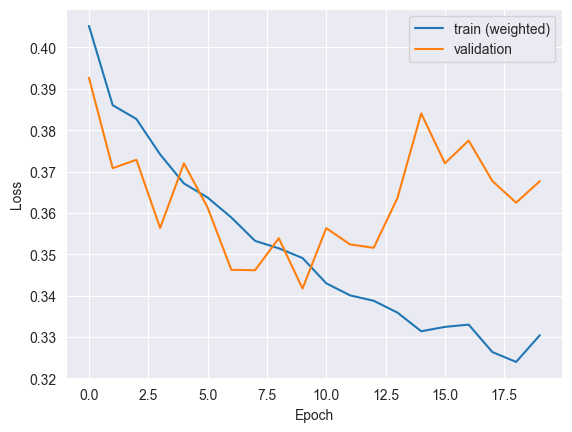

In [16]:
from sklearn.metrics import f1_score

N_EPOCHS = 20
weight_samples = True

# model = ProteinLocalizer().to(device)
# model = TwoStepProteinLocalizer().to(device)
# model = SimpleProteinLocalizer().to(device)
# model = CustomSimpleModel().to(device)
model = PLCNN().to(device)
print("Number of parameters: ", sum([p.numel() for p in model.parameters()]), '\n')

# loss function & optimizer
loss_function = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Gradual transition parameters
start_epoch = 5
end_epoch = 15

# training loop
train_losses = []
val_losses = []

for i in range(1, N_EPOCHS + 1):
    print(f"Epoch {i}")
    train_loss = []
    val_loss = []
    val_f1 = []
    alpha = max(0.0, min(1.0, (i - start_epoch) / (end_epoch - start_epoch)))

    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch, sample_weights = batch
        X_batch, y_batch, sample_weights = X_batch.to(device), y_batch.to(device), sample_weights.to(device)

        # forward pass: run batch through our model, get predictions and compute loss (with sample weights)
        y_hat_batch = model(X_batch)
        loss = loss_function(y_hat_batch, y_batch)

        if weight_samples:
            # Gradual transition for sample weights (early epochs have low weight, later epochs have full weight)
            adjusted_sample_weights = alpha * sample_weights + (1 - alpha)
            # Compute the weighted loss
            loss = (loss * adjusted_sample_weights.unsqueeze(1)).mean()

        train_loss.append(loss.item())

        # backward pass: compute gradients of loss w.r.t. model parameters and update weights
        loss.backward()
        optimizer.step()

    # update learning rate
    scheduler.step(loss)

    model.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # forward pass only
            y_hat_batch = model(X_batch)
            loss = loss_function(y_hat_batch, y_batch)
            avg_loss = torch.mean(loss)
            val_loss.append(avg_loss.item())

            # compute F1 score (mean over all labels)
            y_hat_batch = torch.sigmoid(y_hat_batch)
            y_hat_batch[y_hat_batch >= 0.5] = 1
            y_hat_batch[y_hat_batch < 0.5] = 0
            f1 = f1_score(y_batch.cpu().numpy(), y_hat_batch.cpu().numpy(), average='macro', zero_division=0)
            val_f1.append(f1)


    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)
    mean_val_f1 = np.mean(val_f1)
    print(f"Train loss : {mean_train_loss}")
    print(f"Valid loss : {mean_val_loss}")
    print(f"F1 score   : {mean_val_f1}\n")
    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)

plt.plot(np.arange(len(train_losses)), train_losses, label = "train (weighted)")
plt.plot(np.arange(len(val_losses)), val_losses, label = "validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
model.to('cpu')
model.eval()

for i in range(4):
    print('Label:\n', test_batch[1][i])
    print('Prediction:\n', nn.Sigmoid()(model(test_batch[0])[i]), '\n')

Label:
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Prediction:
 tensor([0.0204, 0.1229, 0.0252, 0.0691, 0.0097, 0.1422, 0.0353, 0.0100, 0.4961,
        0.0143], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Prediction:
 tensor([0.0426, 0.2360, 0.1684, 0.0904, 0.3975, 0.0748, 0.0696, 0.0184, 0.0235,
        0.3898], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Prediction:
 tensor([0.0805, 0.2119, 0.1024, 0.1554, 0.1271, 0.1653, 0.1296, 0.0439, 0.2717,
        0.0562], grad_fn=<SigmoidBackward0>) 

Label:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Prediction:
 tensor([0.0644, 0.0723, 0.0151, 0.1797, 0.0100, 0.0498, 0.0392, 0.0136, 0.5993,
        0.0109], grad_fn=<SigmoidBackward0>) 



In [18]:
# make predictions
model.to(device)
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        X_batch = batch
        X_batch = X_batch.to(device)
        y_hat_batch = nn.Sigmoid()(model(X_batch))
        predictions.append(y_hat_batch)

predictions = torch.cat(predictions, dim=0)
print(predictions.shape)

torch.Size([3847, 10])


In [19]:
# format
#    ID,TARGET
#    2, 1 3
#    5,1
#    6, 2 4

threshold = 0.5
submission = pd.DataFrame()
submission['Image'] = [int(name.split('.')[-2].split('/')[-1]) for name in test_dataset.X]
submission['Label'] = [' '.join([str(i) for i in range(10) if predictions[idx][i] >= threshold]) for idx in range(len(predictions))]
submission.head()

,Image,Label
0,25880,5
1,7810,
2,23748,4
3,24621,9
4,30169,9


In [20]:
# save submission
submission.to_csv('submission.csv', index=False)